this revision should include:
 - nodes randomly waking up and taking part in the process. at first, the resolution of the sim remains : one timeslot.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
def simulate(N):
  #all nodes should wake up in the first p timeslots
  p = 3000
  sleep_state = np.random.randint(0,p,N)
  #print(sleep_state)
  s = np.min(sleep_state)
  sleep_state = sleep_state - s
  #print(sleep_state)
  aMinBE = 3  # Minimum Backoff Exponent
  aMaxBE = 5  # Maximum Backoff Exponent
  macMaxCSMABackoffs = 5  # Maximum CSMA backoffs
  packet = 2 #packet length in time-slots
  RT_max = 4
  ACK = 1 #12 SYMBOLS TURNAROUND TIME + ack
  MaxAckWait = 3 #timeslots - typically 54
  NB = np.zeros(N, dtype=int)  # Number of backoffs
  BE = np.full(N, aMinBE, dtype=int)  # Backoff exponent
  delay = np.random.randint(0, 2**aMinBE, N)  # Delay values
  tx_packet = np.zeros(N, dtype=int)  # Time remaining in busy state for each node
  RT = np.zeros(N,dtype=int)
  channel_busy = 0 #timeslot left for busy channel
  #Tracking variables
  nbTx= np.zeros(N, dtype=int)
  nbCol = np.zeros(N, dtype=int)
  nbFail = np.zeros(N, dtype=int)
  nbBackoff = np.zeros(N,dtype = int)
  nbCCA = np.zeros(N, dtype=int)
  nbRx = np.zeros(N,dtype = int)
  delay_n = delay
  waitAck = np.zeros(N,dtype=int)
  k=0
  id = 0 #count timeslots in which no node is active

  while np.any(delay > -10): #while there are still nodes with packets
     #assign delay = -9 to nodes who are still sleeping
      #print(f"sleep state is {sleep_state}")
      delay_n = np.where(sleep_state!=0,-9,delay_n)
      delay = delay_n
      op = np.where((waitAck>0) & (delay>-10))
      waitAck[op] -=1
      inx = np.where((delay != -100) & (delay != -200))
      #print(f'{np.all(delay[inx])} delay inx')
      if np.all(delay[inx] == -9) :
          id += 1 
          #print("idle timeslot")
      if (np.any(waitAck[op]==0)):
        #resetCounters
        delay_n[op] = np.random.randint(0, 2**aMinBE, op[0].size)  # Delay value
      if channel_busy>0:
        channel_busy -=1
        if channel_busy==0:
          h = np.where(delay==-3)
          waitAck[h] = MaxAckWait
      #print(f"Currently simulating slot {k}:")
      #check to see if any node is ready for CCA
      #print(f"Channel is Busy for {channel_busy} more time-slots")
      #print(f"Backoff Counter at the start of {k} slot is {delay}")
     # print("Wait Ack" + str(waitAck))
      bo = np.where(delay>-1) #nodes either in backoff or cca
      nbBackoff[bo]+=1
      delay_n[bo] = delay_n[bo] -1 #decrement counter
      arg_cca = np.where(delay == -1) #nodes that just did cca
      nbCCA[arg_cca] += 1 #keep track of number of cca performed
      if channel_busy == 0:
        cca_no = arg_cca[0].size
        if cca_no > 1:
          #case of collision
          delay_n[arg_cca] = -3 #tx_col
          channel_busy = packet + 1
          #update metrics
          nbCol[arg_cca] +=1
          #update RT
          RT[arg_cca] +=1
          #print("RT IS " + str(RT))
          NB[arg_cca] = 0 #reset
          ux = np.where((RT>RT_max) & (delay>-50))
          delay_n[ux] = -200 #failed due to reaching the max levels of retries
        elif cca_no == 1:
          delay_n[arg_cca] = -2 #tx_col
          channel_busy = packet + ACK +1
          nbTx[arg_cca] +=1
          delay_n[arg_cca] = -100 #succesfull transmission
          #check to see if that is the last node
          mask = np.arange(delay.shape[0]) != arg_cca
          #print(f'mask is {mask}')
          if np.all(delay[mask.flatten()] < -10):
            k += packet  #and one timeslot is added to the end of the algorithm
      else:
        NB[arg_cca] +=1
        if arg_cca[0].size>0:  # This checks if arg_cca is not empty
          for i in arg_cca[0]:
            BE[i] = np.min(np.array([BE[i] + 1, aMaxBE]))
            #print(f"BE is {BE}")
        delay_n[arg_cca] = np.array([np.random.randint(1, 2**BE[i]) for i in arg_cca])  # Delay value
        f = np.where(NB>macMaxCSMABackoffs)
        delay_n[f] = -200 #failed to transmit due to reaching max value of BackOffs
      s_wu = np.where(sleep_state == 1)
      #print(f"s_wu is {s_wu} and s_wu size is {s_wu[0].size} ")
     # print(f"delay n[wu]  shape is {delay_n[s_wu[0]].shape}")
      #print(delay_n)
      delay_n[s_wu] = np.random.randint(0,2**aMinBE,s_wu[0].size)
      sleep_state = np.where(sleep_state != 0, sleep_state - 1, sleep_state)
      k += 1
     # print("NB status is " + str(NB))
     # print("k is " + str(k))
  transmissions = (delay == -100).sum()
  throughput = np.sum(transmissions*packet)/(k-1-id)
  col = (nbCol == 1).sum()
  bo_mean = np.mean(nbBackoff)
  cca_mean = np.mean(nbCCA)
  return np.array([throughput,col,transmissions,bo_mean,cca_mean])

In [3]:
nodes = 5
simulate(nodes)

array([0.4, 0. , 5. , 4.8, 1. ])

In [4]:
nodes = np.linspace(5,50,5,dtype=int)
thr = np.zeros(nodes.shape)
col = np.zeros(nodes.shape)
tx = np.zeros(nodes.shape)
bo = np.zeros(nodes.shape)
cca = np.zeros(nodes.shape)
i=0
for n in nodes:
  thr_h = np.zeros((5000,))
  col_h = np.zeros((5000,))
  tx_h = np.zeros((5000,))
  bo_h = np.zeros((5000,))
  cca_h = np.zeros((5000,))
  for j in range(0,5000):
    var = simulate(n)
    #print(var[1])
    thr_h[j] = var[0]
    col_h[j] = var[1]
    tx_h[j] = var[2]
    bo_h[j] = var[3]
    cca_h[j] = var[4]
    print(f'j is {j}')
  #print(thr_h)
  thr[i] = np.mean(thr_h)
  col[i] = np.mean(col_h)
  tx[i] = np.mean(tx_h)
  bo[i] = np.mean(bo_h)
  cca[i] = np.mean(cca_h)
  print(f'i is {i}')
  i+=1

j is 0
j is 1
j is 2
j is 3
j is 4
j is 5
j is 6
j is 7
j is 8
j is 9
j is 10
j is 11
j is 12
j is 13
j is 14
j is 15
j is 16
j is 17
j is 18
j is 19
j is 20
j is 21
j is 22
j is 23
j is 24
j is 25
j is 26
j is 27
j is 28
j is 29
j is 30
j is 31
j is 32
j is 33
j is 34
j is 35
j is 36
j is 37
j is 38
j is 39
j is 40
j is 41
j is 42
j is 43
j is 44
j is 45
j is 46
j is 47
j is 48
j is 49
j is 50
j is 51
j is 52
j is 53
j is 54
j is 55
j is 56
j is 57
j is 58
j is 59
j is 60
j is 61
j is 62
j is 63
j is 64
j is 65
j is 66
j is 67
j is 68
j is 69
j is 70
j is 71
j is 72
j is 73
j is 74
j is 75
j is 76
j is 77
j is 78
j is 79
j is 80
j is 81
j is 82
j is 83
j is 84
j is 85
j is 86
j is 87
j is 88
j is 89
j is 90
j is 91
j is 92
j is 93
j is 94
j is 95
j is 96
j is 97
j is 98
j is 99
j is 100
j is 101
j is 102
j is 103
j is 104
j is 105
j is 106
j is 107
j is 108
j is 109
j is 110
j is 111
j is 112
j is 113
j is 114
j is 115
j is 116
j is 117
j is 118
j is 119
j is 120
j is 121
j is 122
j i

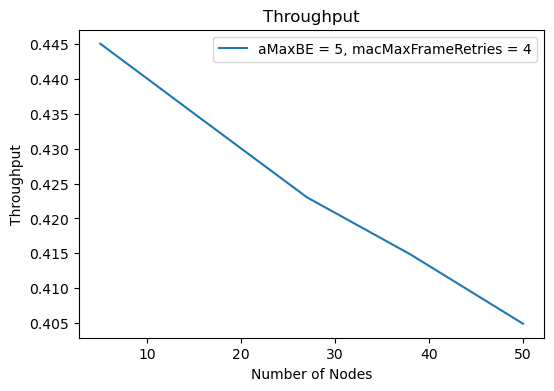

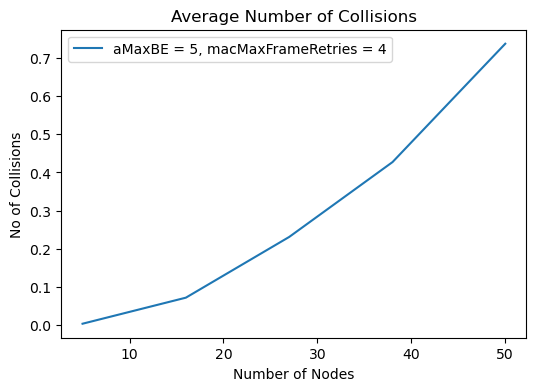

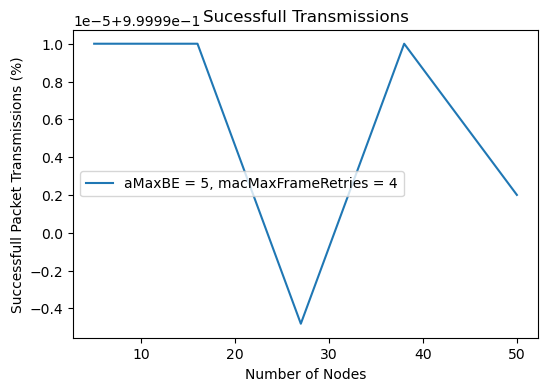

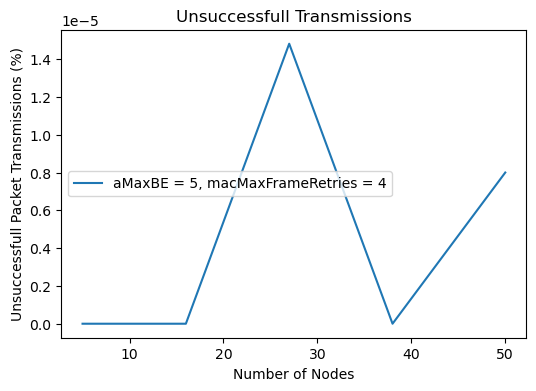

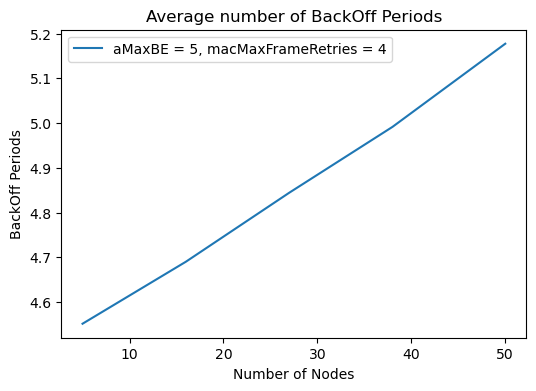

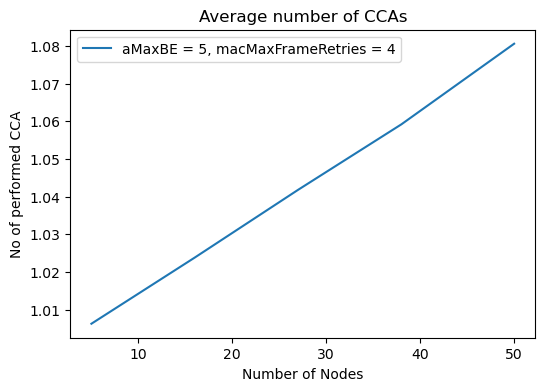

In [5]:
import matplotlib.pyplot as plt
import numpy as np

y_data = [thr, col, tx/nodes, (nodes-tx)/nodes, bo, cca]
np.savez('csma.ca.unslotted.var.sleep', thr=thr, col=col, tx=tx/nodes, f_tx=(nodes-tx)/nodes, bo=bo, cca=cca)
titles = ["Throughput", "Average Number of Collisions", "Sucessfull Transmissions", "Unsuccessfull Transmissions", "Average number of BackOff Periods", "Average number of CCAs"]
y_labels = ["Throughput", "No of Collisions", "Successfull Packet Transmissions (%)", "Unsuccessfull Packet Transmissions (%)", "BackOff Periods", "No of performed CCA"]

for i, y in enumerate(y_data):
    plt.figure(figsize=(6, 4))
    plt.plot(nodes, y, label=f"aMaxBE = 5, macMaxFrameRetries = 4")
    plt.title(titles[i])
    plt.xlabel("Number of Nodes")
    plt.ylabel(y_labels[i])
    plt.legend()  # Add the legend to each plot
    plt.show()


In [17]:
#calculate energy consumption based on simulation results/ start with N = 5
N = nodes[0]
backoffs = bo[0]
collisions = col[0]
tx_all = tx[0]
cca_m = cca[0]
packet = 13

#calculate time in seconds for bo periods
bo_time = backoffs * t_slot
#calculate time spent on cca
cca_time = cca_m * t_slot * (6/20) #cca duration (6 symbols) - (14 symbols cpu on)
#total cpu on - radio off time
cca_time = cca_m * t_slot * (14/20) + bo_time + (collisions/N)* t_slot*(12/20) + (tx_all/N)*t_slot*(12/20) #turnaround_time
#total receiving time
w4ack = (collisions/N)*54*t_symbol #due to collisions
wack = (tx_all/N)*8*t_symbol #successful
#total transmitting time
w4rx = (collisions/N) * t_slot * packet + (tx_all/N)*t_slot*packet

NameError: name 't_slot' is not defined

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
def simulate(N,packet):
  #all nodes should wake up in the first p timeslots
  p = 10*N
  sleep_state = np.random.randint(0,p,N)
  print(sleep_state)
  s = np.min(sleep_state)
  sleep_state = sleep_state - s
  print(sleep_state)
  aMinBE = 3  # Minimum Backoff Exponent
  aMaxBE = 5  # Maximum Backoff Exponent
  macMaxCSMABackoffs = 5  # Maximum CSMA backoffs
  #packet = 13 #packet length in time-slots
  RT_max = 4
  ACK = 1 #12 SYMBOLS TURNAROUND TIME + ack
  MaxAckWait = 3 #timeslots - typically 54
  NB = np.zeros(N, dtype=int)  # Number of backoffs
  BE = np.full(N, aMinBE, dtype=int)  # Backoff exponent
  delay = np.random.randint(0, 2**aMinBE, N)  # Delay values
  tx_packet = np.zeros(N, dtype=int)  # Time remaining in busy state for each node
  RT = np.zeros(N,dtype=int)
  channel_busy = 0 #timeslot left for busy channel
  #Tracking variables
  nbTx= np.zeros(N, dtype=int)
  nbCol = np.zeros(N, dtype=int)
  nbFail = np.zeros(N, dtype=int)
  nbBackoff = np.zeros(N,dtype = int)
  nbCCA = np.zeros(N, dtype=int)
  nbRx = np.zeros(N,dtype = int)
  delay_n = delay
  waitAck = np.zeros(N,dtype=int)
  k=0


  while np.any(delay > -10): #while there are still nodes with packets
      #assign delay = -9 to nodes who are still sleeping
      print(f"sleep state is {sleep_state}")
      delay_n = np.where(sleep_state!=0,-9,delay_n)
      delay = delay_n
      op = np.where((waitAck>0) & (delay>-10))
      waitAck[op] -=1
      if (np.any(waitAck[op]==0)):
        #resetCounters
        delay_n[op] = np.random.randint(0, 2**aMinBE, op[0].size)  # Delay value
      if channel_busy>0:
        channel_busy -=1
        if channel_busy==0:
          h = np.where(delay==-3)
          waitAck[h] = MaxAckWait
      print(f"Currently simulating slot {k}:")
      #check to see if any node is ready for CCA
      print(f"Channel is Busy for {channel_busy} more time-slots")
      print(f"Backoff Counter at the start of {k} slot is {delay}")
      print("Wait Ack" + str(waitAck))
      bo = np.where(delay>-1) #nodes either in backoff or cca
      nbBackoff[bo]+=1
      delay_n[bo] = delay_n[bo] -1 #decrement counter
      arg_cca = np.where(delay == -1) #nodes that just did cca
      nbCCA[arg_cca] += 1 #keep track of number of cca performed
      if channel_busy == 0:
        cca_no = arg_cca[0].size
        if cca_no > 1:
          #case of collision
          delay_n[arg_cca] = -3 #tx_col
          channel_busy = packet + 1
          #update metrics
          nbCol[arg_cca] +=1
          #update RT
          RT[arg_cca] +=1
          print("RT IS " + str(RT))
          NB[arg_cca] = 0 #reset
          ux = np.where((RT>RT_max) & (delay>-50))
          delay_n[ux] = -200 #failed due to reaching the max levels of retries
        elif cca_no == 1:
          delay_n[arg_cca] = -2 #tx_col
          channel_busy = packet + ACK +1
          nbTx[arg_cca] +=1
          delay_n[arg_cca] = -100 #succesfull transmission
      else:
        NB[arg_cca] +=1
        if arg_cca[0].size>0:  # This checks if arg_cca is not empty
          for i in arg_cca[0]:
            BE[i] = np.min(np.array([BE[i] + 1, aMaxBE]))
            print(f"BE is {BE}")
        delay_n[arg_cca] = np.array([np.random.randint(1, 2**BE[i]) for i in arg_cca])  # Delay value
        f = np.where(NB>macMaxCSMABackoffs)
        delay_n[f] = -200 #failed to transmit due to reaching max value of BackOffs
      s_wu = np.where(sleep_state == 1)
      delay_n[s_wu] = np.random.randint(0,2**aMinBE,s_wu[0].size)
      sleep_state = np.where(sleep_state != 0, sleep_state - 1, sleep_state)
      k += 1
      print("NB status is " + str(NB))
      print(" ")
  transmissions = (delay == -100).sum()
  throughput = np.sum(transmissions*packet)/k
  col = (nbCol == 1).sum()
  bo_mean = np.mean(nbBackoff)
  cca_mean = np.mean(nbCCA)
  return np.array([throughput,col,transmissions,bo_mean,cca_mean])

In [ ]:
thr_h = np.zeros((2000,))
col_h = np.zeros((2000,))
tx_h = np.zeros((2000,))
bo_h = np.zeros((2000,))
cca_h = np.zeros((2000,))
for j in range(0,2000):
  var = simulate(10,2)
  #print(var[1])
  thr_h[j] = var[0]
  col_h[j] = var[1]
  tx_h[j] = var[2]
  bo_h[j] = var[3]
  cca_h[j] = var[4]
  #print(thr_h)
thr = np.mean(thr_h)
col = np.mean(col_h)
tx = np.mean(tx_h)
bo = np.mean(bo_h)
cca  = np.mean(cca_h)

Η έξοδος ροής περικόπηκε στις τελευταίες 5000 γραμμές.
Currently simulating slot 62:
Channel is Busy for 0 more time-slots
Backoff Counter at the start of 62 slot is [-100 -100 -100 -100   -9   -3 -100   -3    9   -9]
Wait Ack[0 0 0 0 0 3 0 3 0 0]
NB status is [0 1 0 0 0 0 0 0 1 0]
 
sleep state is [ 0  0  0  0 15  0  0  0  0  8]
Currently simulating slot 63:
Channel is Busy for 0 more time-slots
Backoff Counter at the start of 63 slot is [-100 -100 -100 -100   -9   -3 -100   -3    8   -9]
Wait Ack[0 0 0 0 0 2 0 2 0 0]
NB status is [0 1 0 0 0 0 0 0 1 0]
 
sleep state is [ 0  0  0  0 14  0  0  0  0  7]
Currently simulating slot 64:
Channel is Busy for 0 more time-slots
Backoff Counter at the start of 64 slot is [-100 -100 -100 -100   -9   -3 -100   -3    7   -9]
Wait Ack[0 0 0 0 0 1 0 1 0 0]
NB status is [0 1 0 0 0 0 0 0 1 0]
 
sleep state is [ 0  0  0  0 13  0  0  0  0  6]
Currently simulating slot 65:
Channel is Busy for 0 more time-slots
Backoff Counter at the start of 65 slot is [-1

In [ ]:
print(thr)
print(tx)
print(cca)
print(bo)
print(col)

0.20897229493770844
9.9975
1.5641999999999998
9.887
0.9055


In [ ]:
data_rate = 250e3 #bps
t_symbol = (1/data_rate) * 4
t_slot = 20 * t_symbol
t_slot
N = 10
packet = 2 #20 byte
#calculate time in seconds for bo periods
bo_time = bo * t_slot
#calculate time spent on cca
cca_time = cca* t_slot * (6/20) #cca duration (6 symbols) - (14 symbols cpu on)
#total cpu on - radio off time
cca_time = cca * t_slot * (14/20) + bo_time + (col/N)* t_slot*(12/20) + (tx/N)*t_slot*(12/20) #backoff periods + turnaround_time (for succesfull and unsuccessful)
#total receiving time
w4ack = (col/N)*54*t_symbol #due to collisions
wack = (tx/N)*8*t_symbol #successful
#total transmitting time
w4rx = (col/N) * t_slot * packet + (tx/N)*t_slot*packet